
# Clean-Clean Entity Resolution Tutorial

In this notebook we present the pyJedAI approach in the well-known ABT-BUY dataset. Clean-Clean ER in the link discovery/deduplication between two sets of entities.


Dataset: __Abt-Buy dataset__ (D1)

The Abt-Buy dataset for entity resolution derives from the online retailers Abt.com and Buy.com. The dataset contains 1076 entities from abt.com and 1076 entities from buy.com as well as a gold standard (perfect mapping) with 1076 matching record pairs between the two data sources. The common attributes between the two data sources are: product name, product description and product price.

## How to install?

pyJedAI is an open-source library that can be installed from PyPI.

For more: [pypi.org/project/pyjedai/](https://pypi.org/project/pyjedai/)

In [ ]:
!pip install pyjedai -U

In [2]:
!pip show pyjedai

Name: pyjedai
Version: 0.1.0
Summary: An open-source library that builds powerful end-to-end Entity Resolution workflows.
Home-page: 
Author: 
Author-email: Konstantinos Nikoletos <nikoletos.kon@gmail.com>, George Papadakis <gpapadis84@gmail.com>, Jakub Maciejewski <jacobb.maciejewski@gmail.com>, Manolis Koubarakis <koubarak@di.uoa.gr>
License: Apache Software License 2.0
Location: /home/jm/anaconda3/envs/pyjedai-new/lib/python3.8/site-packages
Requires: faiss-cpu, gensim, matplotlib, matplotlib-inline, networkx, nltk, numpy, optuna, ordered-set, pandas, pandas-profiling, pandocfilters, plotly, py-stringmatching, PyYAML, rdflib, rdfpandas, regex, scipy, seaborn, sentence-transformers, strsim, strsimpy, tomli, tqdm, transformers, valentine
Required-by: 


Imports

In [3]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph

In [4]:
import pyjedai
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation

[nltk_data] Downloading package stopwords to /home/jm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Workflow Architecture

![workflow-example.png](https://github.com/AI-team-UoA/pyJedAI/blob/main/docs/img/workflow-example.png?raw=true)

# Data Reading

pyJedAI in order to perfrom needs only the tranformation of the initial data into a pandas DataFrame. Hence, pyJedAI can function in every structured or semi-structured data. In this case Abt-Buy dataset is provided as .csv files. 


In [5]:
from pyjedai.datamodel import Data
from pyjedai.evaluation import Evaluation

In [6]:
d1 = pd.read_csv("./../data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False)
d2 = pd.read_csv("./../data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False)
gt = pd.read_csv("./../data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(dataset_1=d1,
            id_column_name_1='id',
            dataset_2=d2,
            id_column_name_2='id',
            ground_truth=gt)

pyJedAI offers also dataset analysis methods (more will be developed)

In [7]:
data.print_specs()

------------------------- Data -------------------------
Type of Entity Resolution:  Clean-Clean
Dataset-1:
	Number of entities:  1076
	Number of NaN values:  0
	Attributes: 
		 ['name', 'description', 'price']
Dataset-2:
	Number of entities:  1076
	Number of NaN values:  0
	Attributes: 
		 ['name', 'description', 'price']

Total number of entities:  2152
Number of matching pairs in ground-truth:  1076
-------------------------------------------------------- 



In [8]:
data.dataset_1.head(5)

,id,name,description,price
0,0,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,
1,1,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399
2,2,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,49
3,3,Sony 5 Disc CD Player - CDPCE375,Sony 5 Disc CD Player- CDPCE375/ 5 Disc Change...,
4,4,Bose 27028 161 Bookshelf Pair Speakers In Whit...,Bose 161 Bookshelf Speakers In White - 161WH/ ...,158


In [9]:
data.dataset_2.head(5)

,id,name,description,price
0,0,Linksys EtherFast EZXS88W Ethernet Switch - EZ...,Linksys EtherFast 8-Port 10/100 Switch (New/Wo...,
1,1,Linksys EtherFast EZXS55W Ethernet Switch,5 x 10/100Base-TX LAN,
2,2,Netgear ProSafe FS105 Ethernet Switch - FS105NA,NETGEAR FS105 Prosafe 5 Port 10/100 Desktop Sw...,
3,3,Belkin Pro Series High Integrity VGA/SVGA Moni...,1 x HD-15 - 1 x HD-15 - 10ft - Beige,
4,4,Netgear ProSafe JFS516 Ethernet Switch,Netgear ProSafe 16 Port 10/100 Rackmount Switc...,


In [10]:
data.ground_truth.head(3)

,D1,D2
0,206,216
1,60,46
2,182,160


### Data cleaning step (optional)

pyJedAI offers 4 types of text cleaning/processing. 

- Stopwords removal
- Punctuation removal
- Numbers removal
- Unicodes removal

In [11]:
data.clean_dataset(remove_stopwords = False, 
                   remove_punctuation = False, 
                   remove_numbers = False,
                   remove_unicodes = False)

## Block Building

It clusters entities into overlapping blocks in a lazy manner that relies on unsupervised blocking keys: every token in an attribute value forms a key. Blocks are then extracted, possibly using a transformation, based on its equality or on its similarity with other keys.

The following methods are currently supported:

- Standard/Token Blocking
- Sorted Neighborhood
- Extended Sorted Neighborhood
- Q-Grams Blocking
- Extended Q-Grams Blocking
- Suffix Arrays Blocking
- Extended Suffix Arrays Blocking

In [12]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

In [13]:
bb = StandardBlocking()
blocks = bb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Standard Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [14]:
bb.report()

Method name: Standard Blocking
Method info: Creates one block for every token in the attribute values of at least two entities.
Parameters: Parameter-Free method
Attributes from D1:
	name
Attributes from D2:
	name
Runtime: 0.4000 seconds


In [15]:
_ = bb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Standard Blocking
***************************************************************************************************************************
Method name: Standard Blocking
Parameters: 
Runtime: 0.4000 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.45% 
	Recall:        99.54%
	F1-score:       0.90%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1071
	False positives: 236447
	True negatives: 1156695
	False negatives: 5
	Total comparisons: 237518
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Block Purging

__Optional step__

Discards the blocks exceeding a certain number of comparisons. 


In [16]:
from pyjedai.block_cleaning import BlockPurging

In [17]:
bp = BlockPurging()
cleaned_blocks = bp.process(blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/2934 [00:00<?, ?it/s]

In [18]:
bp.report()

Method name: Block Purging
Method info: Discards the blocks exceeding a certain number of comparisons.
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3224.0
Runtime: 0.0446 seconds


In [19]:
_ = bp.evaluate(cleaned_blocks)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3224.0
Runtime: 0.0446 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      1.12% 
	Recall:        98.61%
	F1-score:       2.21%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Block Cleaning

___Optional step___

Its goal is to clean a set of overlapping blocks from unnecessary comparisons, which can be either redundant (i.e., repeated comparisons that have already been executed in a previously examined block) or superfluous (i.e., comparisons that involve non-matching entities). Its methods operate on the coarse level of individual blocks or entities.

In [20]:
from pyjedai.block_cleaning import BlockFiltering

In [21]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(cleaned_blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
bf.evaluate(filtered_blocks)

***************************************************************************************************************************
                                         Μethod:  Block Filtering
***************************************************************************************************************************
Method name: Block Filtering
Parameters: 
	Ratio: 0.8
Runtime: 0.2376 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      2.56% 
	Recall:        96.10%
	F1-score:       4.99%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 2.562450436161776,
 'Recall %': 96.09665427509294,
 'F1 %': 4.991792990248141,
 'True Positives': 1034,
 'False Positives': 39318,
 'True Negatives': 1156658,
 'False Negatives': 42}

## Comparison Cleaning - Meta Blocking

___Optional step___

Similar to Block Cleaning, this step aims to clean a set of blocks from both redundant and superfluous comparisons. Unlike Block Cleaning, its methods operate on the finer granularity of individual comparisons.

The following methods are currently supported:

- Comparison Propagation
- Cardinality Edge Pruning (CEP)
- Cardinality Node Pruning (CNP)
- Weighed Edge Pruning (WEP)
- Weighed Node Pruning (WNP)
- Reciprocal Cardinality Node Pruning (ReCNP)
- Reciprocal Weighed Node Pruning (ReWNP)
- BLAST

Most of these methods are Meta-blocking techniques. All methods are optional, but competive, in the sense that only one of them can part of an ER workflow. For more details on the functionality of these methods, see here. They can be combined with one of the following weighting schemes:

- Aggregate Reciprocal Comparisons Scheme (ARCS)
- Common Blocks Scheme (CBS)
- Enhanced Common Blocks Scheme (ECBS)
- Jaccard Scheme (JS)
- Enhanced Jaccard Scheme (EJS)

In [23]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [24]:
mb = WeightedEdgePruning(weighting_scheme='EJS')
candidate_pairs_blocks = mb.process(filtered_blocks, data, tqdm_disable=True)

In [25]:
_ = mb.evaluate(candidate_pairs_blocks)

***************************************************************************************************************************
                                         Μethod:  Weighted Edge Pruning
***************************************************************************************************************************
Method name: Weighted Edge Pruning
Parameters: 
	Node centric: False
	Weighting scheme: EJS
Runtime: 0.5876 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     10.86% 
	Recall:        91.45%
	F1-score:      19.41%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Want to export pairs in this step?

Every step provides a method named `export_to_df` that exports all pairs in dataframe. If you wish to export them in a file use `.to_csv` from pandas.

In [26]:
pairs_df=mb.export_to_df(candidate_pairs_blocks)

In [27]:
pairs_df.head(5)

,id1,id2
0,0,205
1,0,193
2,0,53
3,0,55
4,0,697


## Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [28]:
from pyjedai.matching import EntityMatching

In [29]:
em = EntityMatching(
    metric='cosine',
    tokenizer='char_tokenizer',
    vectorizer='tfidf',
    qgram=3,
    similarity_threshold=0.0
)

pairs_graph = em.predict(candidate_pairs_blocks, data, tqdm_disable=True)

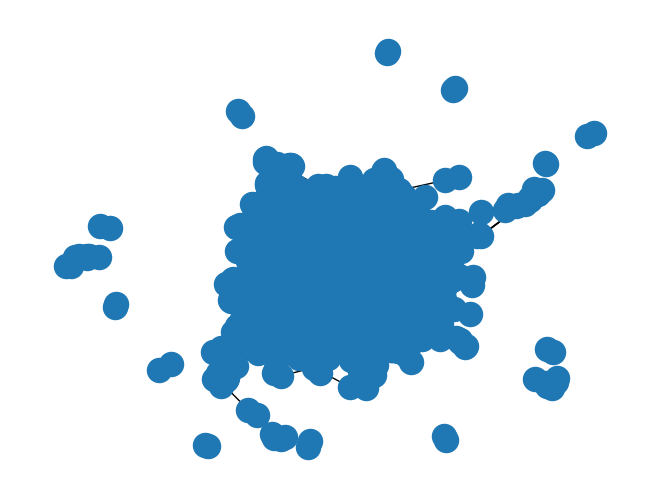

In [30]:
draw(pairs_graph)

In [31]:
_ = em.evaluate(pairs_graph)

***************************************************************************************************************************
                                         Μethod:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Metric: cosine
	Attributes: None
	Similarity threshold: 0.0
	Tokenizer: char_tokenizer
	Vectorizer: tfidf
	Qgrams: 3
Runtime: 2.3469 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     10.86% 
	Recall:        91.45%
	F1-score:      19.41%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### How to set a valid similarity threshold?

Configure similariy threshold with a Grid-Search or with an Optuna search. Also pyJedAI provides some visualizations on the distributions of the scores.

For example with a classic histogram:


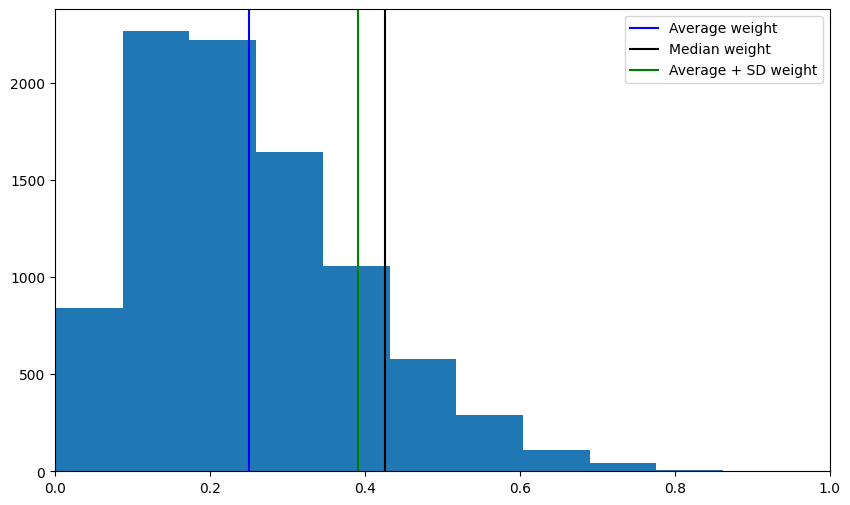

In [32]:
em.plot_distribution_of_all_weights()

Or with a range 0.1 from 0.0 to 1.0 grouping:

Distribution-% of predicted scores:  [13.551092474067536, 28.8126241447804, 25.5131317589936, 17.325093798278527, 9.00463473846833, 3.8402118737585518, 1.4566320900463474, 0.4634738468329287, 0.03310527477378062, 0.0]


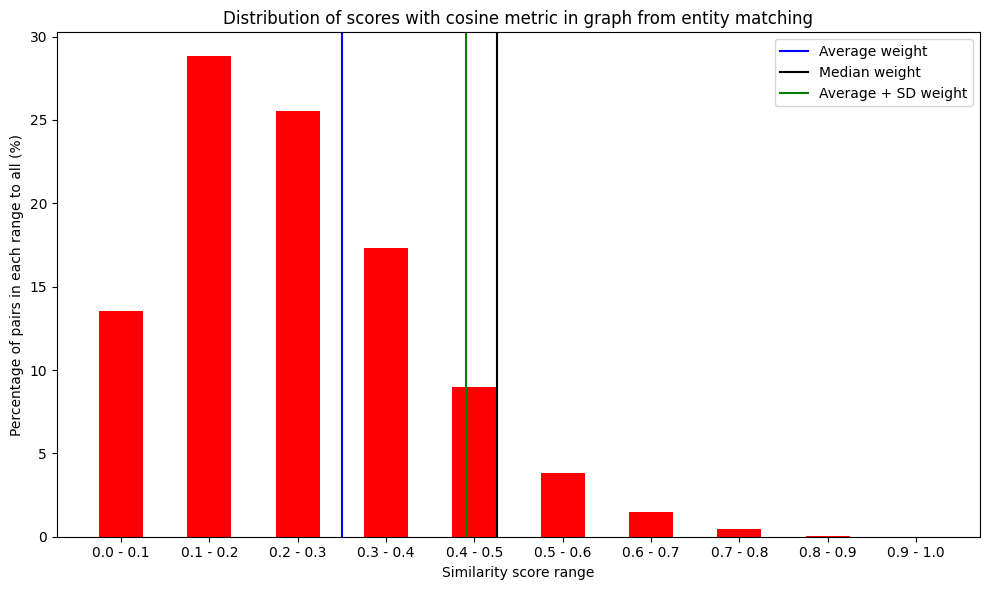

In [33]:
em.plot_distribution_of_scores()

## Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [34]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [35]:
ccc = UniqueMappingClustering()
clusters = ccc.process(pairs_graph, data, similarity_threshold=0.17)

In [36]:
ccc.report()

Method name: Unique Mapping Clustering
Method info: Prunes all edges with a weight lower than t, sorts the remaining ones indecreasing weight/similarity and iteratively forms a partition forthe top-weighted pair as long as none of its entities has alreadybeen matched to some other.
Parameters:  None
Runtime: 0.1299 seconds


In [37]:
_ = ccc.evaluate(clusters)

***************************************************************************************************************************
                                         Μethod:  Unique Mapping Clustering
***************************************************************************************************************************
Method name: Unique Mapping Clustering
Parameters: 
Runtime: 0.1299 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     92.69% 
	Recall:        86.06%
	F1-score:      89.25%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


<hr>
<div align="right">
K. Nikoletos, J. Maciejewski, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>